In [ ]:
%pip install torchviz
%pip install torchsummary
import torch
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from torch.nn import Conv2d, MaxPool2d, Parameter
from torch.nn.functional import relu
from torchviz import make_dot, make_dot_from_trace
from torchvision import models
from sklearn.metrics import confusion_matrix

import os
import librosa
from scipy.io import wavfile
import numpy as np
from sklearn.model_selection import train_test_split

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

Running on cuda.


### Get Data

First, we're going to clone the Microsoft Scalable Noisy Speech Dataset **(MS-SNSD)** repository so we can access the helpful file structure they've laid out.



In [ ]:
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 29924 (delta 2), reused 7 (delta 1), pack-reused 29915
Receiving objects: 100% (29924/29924), 3.93 GiB | 44.83 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Updating files: 100% (24399/24399), done.


We also want to get our custom synthesizer file, so we'll clone our own repo.

In [ ]:
!git clone https://github.com/jblake05/CS0451_Denoising.git

Cloning into 'CS0451_Denoising'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 96 (delta 32), reused 70 (delta 21), pack-reused 0
Receiving objects: 100% (96/96), 2.37 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (32/32), done.


Use the copy command line program to move the synthesizer file to the directory it needs to be in to work.

In [ ]:
!cp CS0451_Denoising/synthesizer.py MS-SNSD

#### We'll then run synthesizer.py to generate noisy speech files
---
The repo initially contains a folder of clean speech with no noise, and pure noise files with no speech. There is a test and train folder for each.

Their code with create a new test and train folder of speech combined with noise - this is what we'll be comparing to the clean speech files.



In [ ]:
!python MS-SNSD/synthesizer.py

We now have 3 new folders:


*   CleanSpeech_training - clean speech (no noise)
*   Noise_training - just background noise (no speech)
*   NoisySpeech_training - combination of speech and noise.





#### Declare our sample rate globally
Sample rate is the amount of samples (datapoints) per second in the audio files contained within the MS-SNSD dataset.

In [ ]:
SRATE = 16000

Next, we can declare our directories to the data made by synthesizer.py

In [ ]:
clean_train_dir = "./MS-SNSD/CleanSpeech_training/"

df_clean_train = os.listdir(clean_train_dir)

len(df_clean_train)

1226

In [ ]:
clean_speech_dir = "./MS-SNSD/CleanSpeech_training/"
clean_speech = os.listdir(clean_speech_dir)

noise_dir = "./MS-SNSD/Noise_training/"
noise = os.listdir(noise_dir)

noisy_speech_dir = "./MS-SNSD/NoisySpeech_training/"
noisy_speech = os.listdir(noisy_speech_dir)

len(clean_speech), len(noise), len(noisy_speech)

(1226, 1474, 1474)

After this, we can create a test mels-spectrogram using librosa:

In [ ]:
num_seconds = 10

data, srate = librosa.load(path=clean_speech_dir + clean_speech[0], sr=SRATE)
mels = librosa.feature.melspectrogram(y=data, sr=srate)

mels.shape

(128, 366)

Plotting the spectrogram array with matplotlib, we see a spectrogram with power levels displayed across different frequencies and time:

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

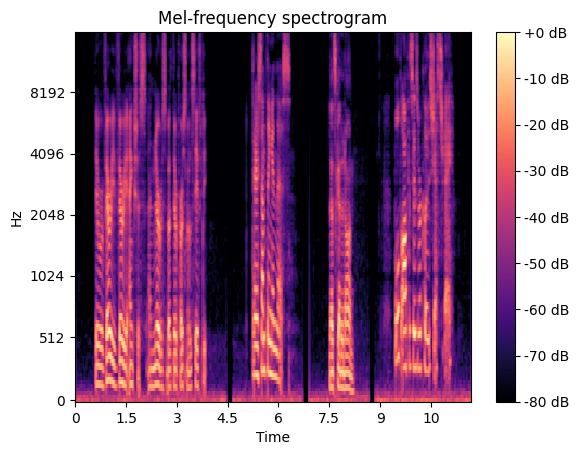

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mels, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=srate,
                         fmax=16000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
S_dB.shape

(128, 366)

Using our test spectrogram, we can create an empty tensor with one color channel and the same dimensions as features

In [ ]:
# create our torch tensor X

X = torch.empty((len(noisy_speech) + len(clean_speech), 1, S_dB.shape[0], S_dB.shape[1]))

Then, we can populate X by iterating over the files in our directories, starting with the noisy speech data

In [ ]:
for i in range(0, len(noisy_speech)):
    data, srate = librosa.load(noisy_speech_dir + noisy_speech[i], sr=SRATE)
    data = data[:srate*10]
    mels = librosa.feature.melspectrogram(y=data, sr=srate)
    S_dB = librosa.power_to_db(mels, ref=np.max)

    X[i][0] = torch.tensor(S_dB)

    i += 1

In [ ]:
X.shape

torch.Size([2700, 1, 128, 313])

Then, we can populate X with our clean speech data

In [ ]:
for i in range(len(noisy_speech), len(noisy_speech) + len(clean_speech)):
    # can grab more from just the clean_train folder, but right now I'm just grabbing what formed the training data
    data, srate = librosa.load(clean_speech_dir + clean_speech[i - len(noisy_speech)], sr=SRATE)
    data = data[:srate*10]
    mels = librosa.feature.melspectrogram(y=data, sr=srate)
    S_dB = librosa.power_to_db(mels, ref=np.max)

    X[i][0] = torch.tensor(S_dB)

    i += 1

# move X_train to GPU if available
X = X.to(device)

After this, we can populate the y tensor by adding ones if its index is less than the amount of noisy speech files, adding 0 after that

In [ ]:
y = torch.empty((len(noisy_speech) + len(clean_speech)), dtype=torch.long)
for i in range(0, y.shape[0]):
    y[i] = 1 if i < len(noisy_speech) else 0

# move y to GPU if available
y = y.to(device)
y

tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')

We can then change these tensors into train and test values using scikit's train_test_split:

In [ ]:
# divide data into train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, test_size = 0.2)

### Data Loaders

We then create dataloaders for training and testing data to be used in batch training

In [ ]:
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train),
    batch_size = 32,
    shuffle = True
)

data_loader_val = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_val, y_val),
    batch_size = 32,
    shuffle = True
)

In [ ]:
X_dl, y_dl = next(iter(data_loader_train))
print(X_dl.size(), y_dl.size())

torch.Size([32, 1, 128, 313]) torch.Size([32])


We then can train a linear model using just one fully connected layer. This pipeline converts the shape of the spectrogram into 2 classification options: with noise or without noise.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*313, 2)
        )

    # this is the customary name for the method that computes the scores
    # the loss is usually computed outside the model class during the training loop
    def forward(self, x):
        return self.pipeline(x)

    def predict(self, x):

        scores = self.forward(x)
        return torch.argmax(scores, dim = 1)

model = LinearModel().to(device)

In [ ]:
scores = model(X_train)
scores.size()

torch.Size([2160, 2])

In [ ]:
torch.argmax(scores, dim = 1)

tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0')

Construct a summary so that we can see what happens to the data in each layer of the pipeline

In [ ]:
from torchsummary import summary
summary(model, input_size=(128, 313))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 40064]               0
            Linear-2                    [-1, 2]          80,130
Total params: 80,130
Trainable params: 80,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 0.31
Params size (MB): 0.31
Estimated Total Size (MB): 0.76
----------------------------------------------------------------


We can also add evaluation and training functions to train and test our models on the data. These are standard functions that compare predicted values to target values and backpropagate loss values, respectively.

In [ ]:
def evaluate(model, X, y, multichannel=False):
  # start counting total observations and correct predictions
  total = 0
  total_correct = 0

  X, y = X.to(device), y.to(device)

  scores = model.forward(X)
  y_pred = torch.argmax(scores, dim = 1)

  total += X.size(0)
  total_correct += (y_pred == y).sum().item()

  print(f"validation accuracy = {total_correct / total:.3f}")

In [ ]:
evaluate(model, X_train, y_train)

validation accuracy = 0.607


In [ ]:
import torch.optim as optim
def train(model, X, y, lr = 0.1, k_epochs = 1, print_every = 2000, evaluate_after_epoch = True, multichannel = False, **opt_kwargs):

    # cross-entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # optimizer is SGD with momentum
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            if multichannel:
                X = torch.tile(X, dims = (1, 3, 1, 1))
                print("multichannel = True")
            X, y = X.to(device), y.to(device)

            # clear any accumulated gradients
            optimizer.zero_grad()

            # compute the loss
            y_pred = model(X)

            loss   = loss_fn(y_pred, y)

            # compute gradients and carry out an optimization step
            loss.backward()
            optimizer.step()

            if (i + 1) % print_every == 0:
                print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            evaluate(model, X, y, multichannel = multichannel)

In [ ]:
# train(model, X_train, y=y_train, k_epochs=30)

In [ ]:
# evaluate(model, X_val, y_val)

## Convolutional Model

In previous runs of this model, we've found that the model needs convolutional layers to successfully and accurately predict the noise of an audio file.



In [ ]:
import torch.nn as nn
from torch.nn import ReLU

class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    #self.conv = nn.Conv2d(1, 100, 5)

    self.pipeline = torch.nn.Sequential(

        # Convolution
        nn.Conv2d(1, 100, 5, padding = 2),
        ReLU(),

        # Linear
        nn.Flatten(),
        nn.Linear(100*128*313, 2)


    )

  def forward(self, x):
    return self.pipeline(x)

model = ConvNet().to(device)

In [ ]:
X_train.size()

torch.Size([2160, 1, 128, 313])

What does the new model look like?

In [ ]:
summary(model, input_size=(1, 128, 313))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 100, 128, 313]           2,600
              ReLU-2        [-1, 100, 128, 313]               0
           Flatten-3              [-1, 4006400]               0
            Linear-4                    [-1, 2]       8,012,802
Total params: 8,015,402
Trainable params: 8,015,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 91.70
Params size (MB): 30.58
Estimated Total Size (MB): 122.43
----------------------------------------------------------------


Training and testing our model here, we find that we achieve an accuracy of almost 99%!

In [ ]:
train(model, X_train, y=y_train, k_epochs=10)

Epoch 0: validation accuracy = 1.000
Epoch 1: validation accuracy = 1.000
Epoch 2: validation accuracy = 1.000
Epoch 3: validation accuracy = 1.000
Epoch 4: validation accuracy = 1.000
Epoch 5: validation accuracy = 1.000
Epoch 6: validation accuracy = 1.000
Epoch 7: validation accuracy = 1.000
Epoch 8: validation accuracy = 1.000
Epoch 9: validation accuracy = 1.000


In [ ]:
evaluate(model, X_val, y_val)

validation accuracy = 0.989


In [ ]:
X_val.shape

torch.Size([540, 1, 128, 313])

In [ ]:
X_train.shape

torch.Size([2160, 1, 128, 313])